In [38]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())    # transforme预处理
print(f'Dataset:{dataset}')
print('=========================')
print(f'Number of graphs:{len(dataset)}')
print(f'Number of features:{dataset.num_features}')
print(f'Number of classes:{dataset.num_classes}')

data = dataset[0]
print()
print(data)
print('=======================================================================')
print(data.num_nodes)
print(data.num_edges)
print(data.num_edges / data.num_nodes)
print(data.train_mask.sum())
print(data.val_mask.sum())
print(data.test_mask.sum())

Dataset:Cora()
Number of graphs:1
Number of features:1433
Number of classes:7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
2708
10556
3.8980797636632203
tensor(140)
tensor(500)
tensor(1000)


In [6]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap='Set2')
    plt.show()

### 试试直接用传统的MLP

In [11]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.ln1 = nn.Linear(dataset.num_features, hidden_channels)
        self.ln2 = nn.Linear(hidden_channels, dataset.num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.ln1(x)
        x = self.relu(x)
        x = self.ln2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (ln1): Linear(in_features=1433, out_features=16, bias=True)
  (ln2): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch:{epoch:03d}, Loss:{loss:.4f}')

Epoch:001, Loss:1.9615
Epoch:002, Loss:1.9538
Epoch:003, Loss:1.9452
Epoch:004, Loss:1.9357
Epoch:005, Loss:1.9250
Epoch:006, Loss:1.9136
Epoch:007, Loss:1.9011
Epoch:008, Loss:1.8877
Epoch:009, Loss:1.8735
Epoch:010, Loss:1.8583
Epoch:011, Loss:1.8421
Epoch:012, Loss:1.8250
Epoch:013, Loss:1.8068
Epoch:014, Loss:1.7875
Epoch:015, Loss:1.7672
Epoch:016, Loss:1.7457
Epoch:017, Loss:1.7232
Epoch:018, Loss:1.6996
Epoch:019, Loss:1.6749
Epoch:020, Loss:1.6492
Epoch:021, Loss:1.6225
Epoch:022, Loss:1.5948
Epoch:023, Loss:1.5663
Epoch:024, Loss:1.5369
Epoch:025, Loss:1.5065
Epoch:026, Loss:1.4754
Epoch:027, Loss:1.4435
Epoch:028, Loss:1.4110
Epoch:029, Loss:1.3780
Epoch:030, Loss:1.3445
Epoch:031, Loss:1.3106
Epoch:032, Loss:1.2764
Epoch:033, Loss:1.2420
Epoch:034, Loss:1.2075
Epoch:035, Loss:1.1730
Epoch:036, Loss:1.1386
Epoch:037, Loss:1.1044
Epoch:038, Loss:1.0706
Epoch:039, Loss:1.0371
Epoch:040, Loss:1.0040
Epoch:041, Loss:0.9715
Epoch:042, Loss:0.9395
Epoch:043, Loss:0.9081
Epoch:044, 

In [13]:
test_acc = test()
print(f'Test Accuracy:{test_acc:.4f}')

Test Accuracy:0.5940


### 两层的GCN

In [33]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)      # 输入特征与邻接矩阵'
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)      # 输入特征与邻接矩阵'
        return x
    
model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 7)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


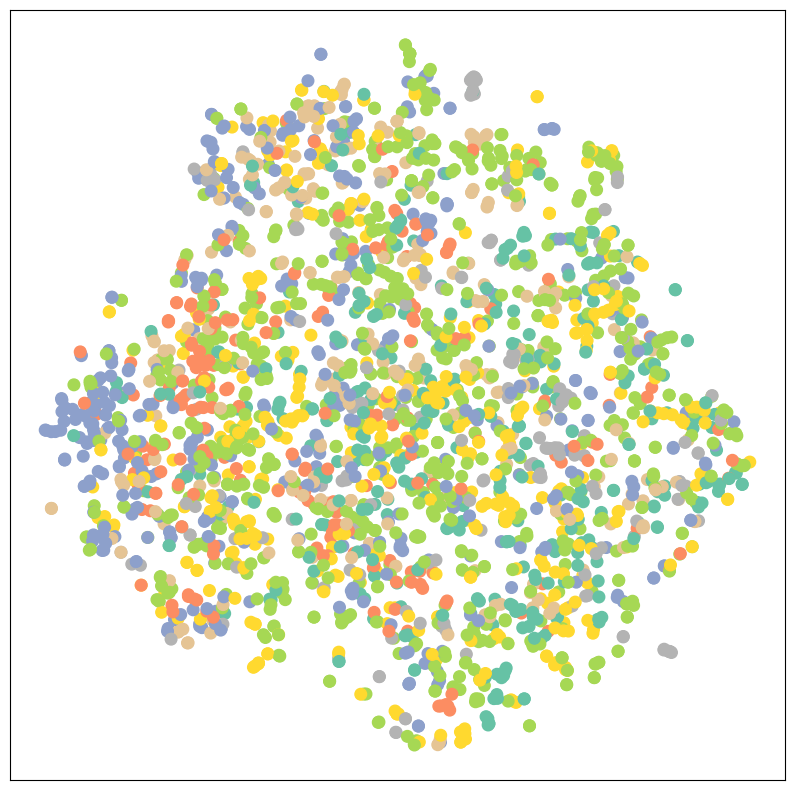

In [34]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### 训练GCN

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch:{epoch:03d}, Loss:{loss:.4f}')

Epoch:001, Loss:1.9455
Epoch:002, Loss:1.9400
Epoch:003, Loss:1.9309
Epoch:004, Loss:1.9180
Epoch:005, Loss:1.9058
Epoch:006, Loss:1.8934
Epoch:007, Loss:1.8779
Epoch:008, Loss:1.8592
Epoch:009, Loss:1.8494
Epoch:010, Loss:1.8245
Epoch:011, Loss:1.8075
Epoch:012, Loss:1.7893
Epoch:013, Loss:1.7692
Epoch:014, Loss:1.7412
Epoch:015, Loss:1.7192
Epoch:016, Loss:1.6908
Epoch:017, Loss:1.6828
Epoch:018, Loss:1.6326
Epoch:019, Loss:1.6089
Epoch:020, Loss:1.5959
Epoch:021, Loss:1.5634
Epoch:022, Loss:1.5426
Epoch:023, Loss:1.4932
Epoch:024, Loss:1.4759
Epoch:025, Loss:1.4473
Epoch:026, Loss:1.4263
Epoch:027, Loss:1.3863
Epoch:028, Loss:1.3437
Epoch:029, Loss:1.3084
Epoch:030, Loss:1.2828
Epoch:031, Loss:1.2385
Epoch:032, Loss:1.2029
Epoch:033, Loss:1.1789
Epoch:034, Loss:1.1715
Epoch:035, Loss:1.1197
Epoch:036, Loss:1.0807
Epoch:037, Loss:1.0921
Epoch:038, Loss:1.0493
Epoch:039, Loss:1.0141
Epoch:040, Loss:0.9605
Epoch:041, Loss:0.9411
Epoch:042, Loss:0.9093
Epoch:043, Loss:0.8912
Epoch:044, 

In [36]:
test_acc = test()
print(f'Test Accuracy:{test_acc:.4f}')

Test Accuracy:0.8030


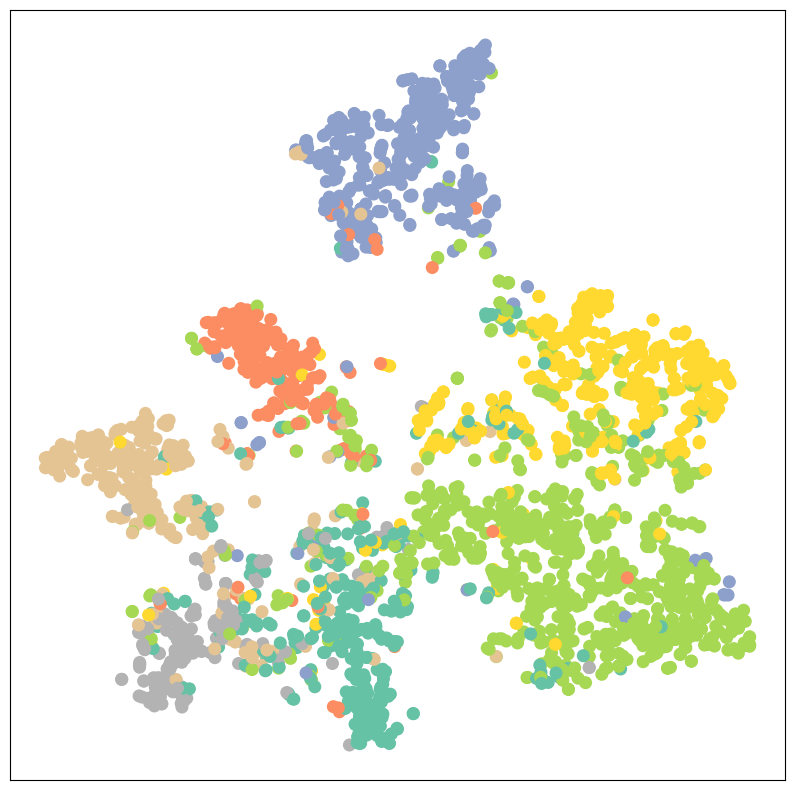

In [37]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)